In [4]:
import os
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import numpy.typing as npt
from natsort import natsorted
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download

e:\Github\tibetan-script-classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
tf.__version__

'2.17.0'

In [10]:
def show_image(image: np.array, cmap: str = "", axis="off") -> None:
    plt.figure(figsize=(24, 13))
    plt.axis(axis)
    
    if cmap != "":
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)


def resize_to_height(image, target_height: int) -> tuple[npt.NDArray, float]:
    scale_ratio = target_height / image.shape[0]
    image = cv2.resize(
        image,
        (int(image.shape[1] * scale_ratio), target_height),
        interpolation=cv2.INTER_LINEAR,
    )
    return image, scale_ratio


def binarize(
        image: np.array, adaptive: bool = True, block_size: int = 51, c: int = 13
) -> np.array:
    line_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if adaptive:
        bw = cv2.adaptiveThreshold(
            line_img,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            block_size,
            c,
        )

    else:
        _, bw = cv2.threshold(line_img, 120, 255, cv2.THRESH_BINARY)

    bw = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
    return bw


def get_class_prediction(image: npt.NDArray, model, tile_size: int, classes: list[str], pre_downscale: bool = True):
    
    if pre_downscale:
        image, _ = resize_to_height(image, tile_size)

    image = binarize(image)
    height_offset = 0
    height, _, _ = image.shape
    width_offset = height // 2

    t_img = tf.image.crop_to_bounding_box(
        image, height_offset, width_offset, tile_size, tile_size
    )

    t_img = tf.expand_dims(t_img, axis=0)
    pred = model.predict(t_img)

    max_value = np.max(pred[0])
    pred_idx = list(pred[0]).index(max_value)
    pred_class = classes[pred_idx]

    return pred_class

In [8]:
model_url = "BDRC/ScriptClassifier_Simple_v1"
local_model_dir = "Models"
snapshot_download(
                repo_id=model_url,
                repo_type="model",
                local_dir=local_model_dir,
            )

Fetching 4 files: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]


'E:\\Github\\tibetan-script-classifier\\Models'

In [9]:
class_model = keras.models.load_model("Models/TibScripts_ConvNext_8Classes_600_binary.keras")
CLASSES = ["UCHAN_Woodblock", "UCHAN_Manuscript", "UCHAN_Modern", "UMED_Druma1", "UMED_Druma2", "UMED_Betsug1", "UMED_Betsug2", "UMED_Slanted_1"]
TILE_SIZE = 600

In [11]:
data_path = "SampleData"
file_ext = "jpg"
images = natsorted(glob(f"{data_path}/*.{file_ext}"))

print(f"Images: {len(images)}")

Images: 5


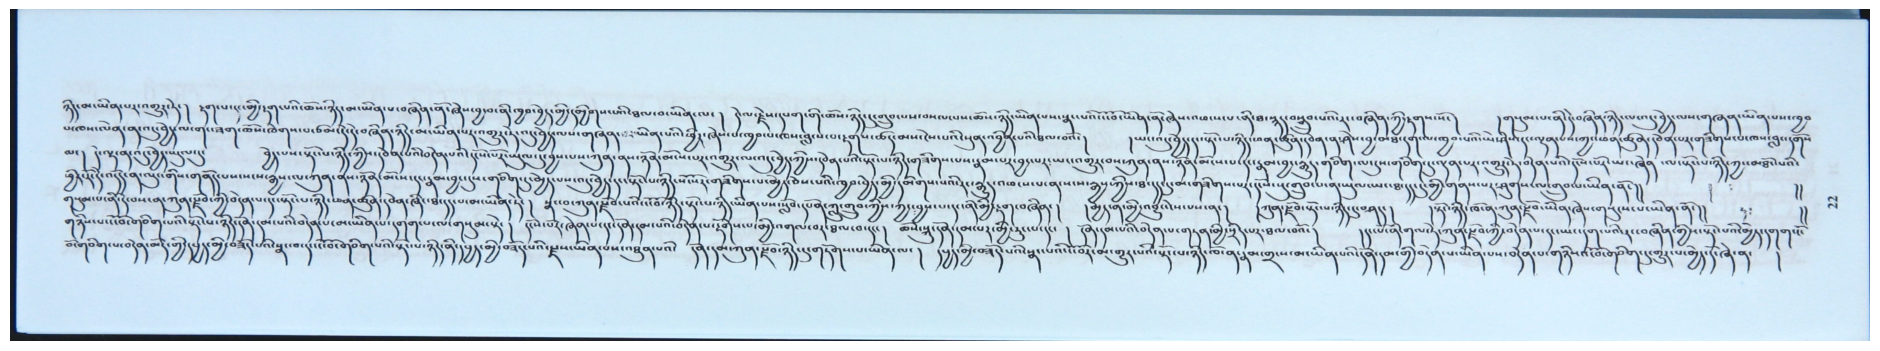

In [14]:
idx = 3
img = cv2.imread(images[idx])
show_image(img)

In [15]:
predicted_class = get_class_prediction(img, class_model, 600, CLASSES)
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
UMED_Druma2
